Lab done by: Dinuke Jayaweera (dinja628) and Jaskirat S Marar (jasma356)

# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

Answer:

Q1: 10496 CUDA cores

Q2: 24 GB

Q3: Activations, input data and weight parameters.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.


In [2]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
# Remove the first 24 covariates (columns)
X = np.load('Mirai_data.npy')[:,24:]
Y = np.load('Mirai_labels.npy')

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
    

The covariates have size (764137, 92).
The labels have size (764137,).


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

Answer:

In [3]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
# Print the number of NaNs (not a number) in the labels
nnanslabels = np.count_nonzero(np.isnan(Y))
print(nnanslabels)
# Print the number of NaNs in the covariates
nnanscov = np.count_nonzero(np.isnan(X))
print(nnanscov)

0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [4]:
# Convert covariates to floats
X = X.astype('float')

# Convert labels to integers
Y = Y.astype('int')

#Remove mean of each covariate (column)
X = X -np.mean(X, axis=0)

#Divide each covariate (column) by its standard deviation
X = X / np.std(X, axis=0)

#Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X, axis=0))
print(np.std(X, axis=0))

[-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2.63270

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [5]:
from sklearn.model_selection import train_test_split

# Your code
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, train_size=0.70 ,test_size=0.30)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%



Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [6]:
from sklearn.model_selection import train_test_split

Xtest, Xval, Ytest, Yval = train_test_split(Xtemp, Ytemp, train_size=0.50, test_size=0.50)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


Answer: Yes, the feature amount is the same for the Xtrain,Xval and Xtest whilst the Y data has only the labels which are as many as the rows in the X data.

# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import activations


# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
        
    model = Sequential()
    
    model.add(Dense(n_nodes,input_dim=input_shape, activation = act_fun))
    
    def additional(use_bn,use_dropout,use_custom_dropout):
        if use_bn == True:
            model.add(BatchNormalization())
        if use_dropout == True:
            model.add(Dropout(0.2))
        if use_custom_dropout == True:
            model.add(myDropout(0.2))
    additional(use_bn,use_dropout,use_custom_dropout)
        
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation = act_fun))
        additional(use_bn,use_dropout,use_custom_dropout)

    model.add(layers.Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = opt , metrics = ['accuracy'])
    
    return model


In [8]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


In [9]:
# Setup some training parameters
batch_size = 1000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build the model
model1 = build_DNN(input_shape,n_layers,n_nodes)

# Train the model, provide training data and validation data
history1 = model1.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs ) 

Epoch 1/20
535/535 [==============================] - 1s 2ms/step - loss: 0.4281 - accuracy: 0.8407 - val_loss: 0.4134 - val_accuracy: 0.8414
Epoch 2/20
535/535 [==============================] - 1s 1ms/step - loss: 0.3988 - accuracy: 0.8407 - val_loss: 0.3800 - val_accuracy: 0.8414
Epoch 3/20
535/535 [==============================] - 1s 1ms/step - loss: 0.3594 - accuracy: 0.8407 - val_loss: 0.3350 - val_accuracy: 0.8414
Epoch 4/20
535/535 [==============================] - 1s 1ms/step - loss: 0.3114 - accuracy: 0.8407 - val_loss: 0.2866 - val_accuracy: 0.8414
Epoch 5/20
535/535 [==============================] - 1s 974us/step - loss: 0.2667 - accuracy: 0.8407 - val_loss: 0.2478 - val_accuracy: 0.8412
Epoch 6/20
535/535 [==============================] - 1s 1ms/step - loss: 0.2351 - accuracy: 0.8532 - val_loss: 0.2234 - val_accuracy: 0.8649
Epoch 7/20
535/535 [==============================] - 1s 998us/step - loss: 0.2162 - accuracy: 0.8769 - val_loss: 0.2093 - val_accuracy: 0.8912
Ep

### 2 layers, 20 nodes

In [221]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2388/2388 [==============================] - 1s 511us/step - loss: 0.1813 - accuracy: 0.9040
Test loss: 0.1813
Test accuracy: 0.9040


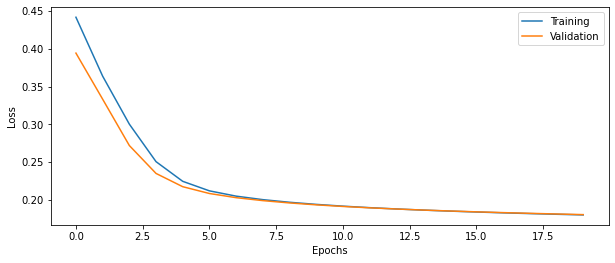

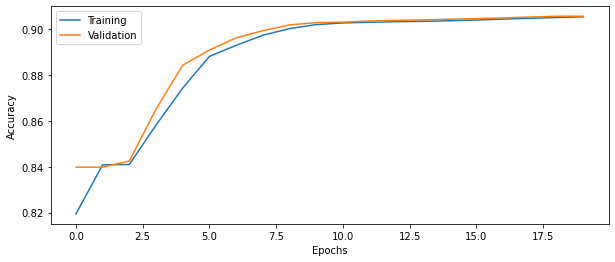

In [222]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


Answer:  

Q5: It could be in that case used for regression, as having no given activation function is having linear activation.

Q6: The glorot_uniform is initialized as default for the Dense Layer, as default the bias weights are true by default in use_bias for the Dense Layer 

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [223]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(Ytrain), y = Ytrain)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight
value1 = class_weights[0]
value2 = class_weights[1]
class_weights = {0: value1,
                 1: value2}


[3.14146393 0.59464449]


### 2 layers, 20 nodes, class weights

In [224]:
# Setup some training parameters
batch_size = 1000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model2 = build_DNN(input_shape,n_layers,n_nodes)

history2 = model2.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
688/688 [==============================] - 1s 2ms/step - loss: 0.6434 - accuracy: 0.8699 - val_loss: 0.5763 - val_accuracy: 0.8793
Epoch 2/20
688/688 [==============================] - 1s 1ms/step - loss: 0.4833 - accuracy: 0.8781 - val_loss: 0.4015 - val_accuracy: 0.8785
Epoch 3/20
688/688 [==============================] - 1s 1ms/step - loss: 0.3265 - accuracy: 0.8786 - val_loss: 0.3155 - val_accuracy: 0.8787
Epoch 4/20
688/688 [==============================] - 1s 1ms/step - loss: 0.2628 - accuracy: 0.8790 - val_loss: 0.2926 - val_accuracy: 0.8791
Epoch 5/20
688/688 [==============================] - 1s 1ms/step - loss: 0.2415 - accuracy: 0.8794 - val_loss: 0.2835 - val_accuracy: 0.8793
Epoch 6/20
688/688 [==============================] - 1s 1ms/step - loss: 0.2323 - accuracy: 0.8796 - val_loss: 0.2793 - val_accuracy: 0.8794
Epoch 7/20
688/688 [==============================] - 1s 1ms/step - loss: 0.2271 - accuracy: 0.8797 - val_loss: 0.2768 - val_accuracy: 0.8794
Epoch 

In [225]:
# Evaluate model on test data
score = model2.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2388/2388 [==============================] - 1s 511us/step - loss: 0.2545 - accuracy: 0.8852
Test loss: 0.2545
Test accuracy: 0.8852


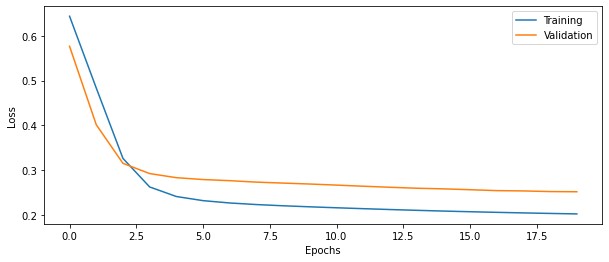

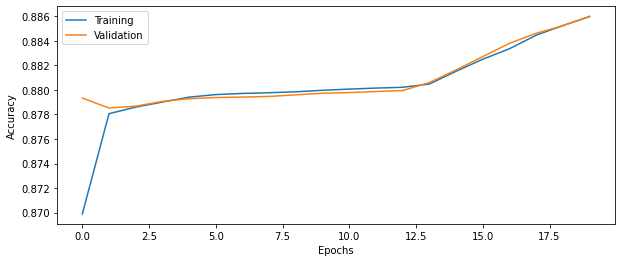

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_634 (Dense)           (None, 20)                1380      
                                                                 
 dense_635 (Dense)           (None, 20)                420       
                                                                 
 dense_636 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [226]:
plot_results(history2)
model2.summary()

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

Answer:

Q7: Using bigger batch sizes speed up the computation time by storing less of the data in the memory.

Q10: It is calculated by sample size devided by batch size so in our case: 534895/1000 = 535 weight updates, 53.5 times with batch size of 1000

Q11: Equal or less than samples size

Q12: Larger batch size means we assume more certainty in one direction and then we need higher learning rate to consider that , learning rate should be decreased to improve the accuracy

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

Answer: 

Q13: Network with 4 layers and 50 nodes have 11,151 parameters in total. The 2 layers with 20 node have 1,821


### 4 layers, 20 nodes, class weights

In [227]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 20
n_layers = 4
input_shape = Xtrain.shape[1]

# Build and train model
model3 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1)

history3 = model3.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 9ms/step - loss: 0.6940 - accuracy: 0.4544 - val_loss: 0.6908 - val_accuracy: 0.8648
Epoch 2/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.7414 - val_loss: 0.6898 - val_accuracy: 0.8608
Epoch 3/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.6955 - val_loss: 0.6869 - val_accuracy: 0.8471
Epoch 4/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.8029 - val_loss: 0.6911 - val_accuracy: 0.8777
Epoch 5/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.8469 - val_loss: 0.6936 - val_accuracy: 0.1617
Epoch 6/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6884 - accuracy: 0.7594 - val_loss: 0.6854 - val_accuracy: 0.8890
Epoch 7/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.8789 - val_loss: 0.6849 - val_accuracy: 0.8773
Epoch 8/20
69/69 [==

In [228]:
# Evaluate model on test data
score = model3.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 525us/step - loss: 0.2761 - accuracy: 0.8795
Test loss: 0.2761
Test accuracy: 0.8795


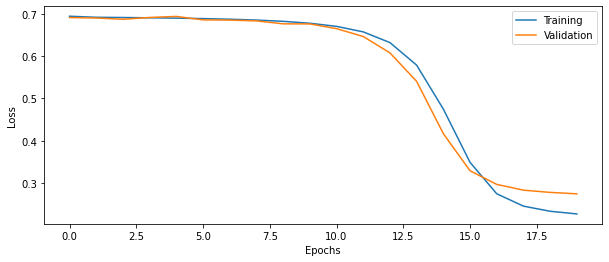

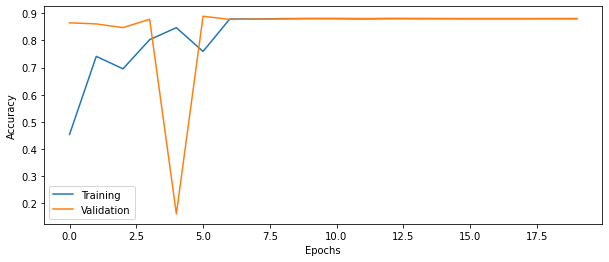

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_637 (Dense)           (None, 20)                1380      
                                                                 
 dense_638 (Dense)           (None, 20)                420       
                                                                 
 dense_639 (Dense)           (None, 20)                420       
                                                                 
 dense_640 (Dense)           (None, 20)                420       
                                                                 
 dense_641 (Dense)           (None, 1)                 21        
                                                                 
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________


In [229]:
plot_results(history3)

model3.summary()

### 2 layers, 50 nodes, class weights

In [230]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 50
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model4 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1)

history4 = model4.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 11ms/step - loss: 0.6008 - accuracy: 0.8705 - val_loss: 0.4830 - val_accuracy: 0.8778
Epoch 2/20
69/69 [==============================] - 1s 9ms/step - loss: 0.3731 - accuracy: 0.8793 - val_loss: 0.3239 - val_accuracy: 0.8793
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2674 - accuracy: 0.8801 - val_loss: 0.2921 - val_accuracy: 0.8806
Epoch 4/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2415 - accuracy: 0.8808 - val_loss: 0.2839 - val_accuracy: 0.8804
Epoch 5/20
69/69 [==============================] - 1s 9ms/step - loss: 0.2316 - accuracy: 0.8806 - val_loss: 0.2802 - val_accuracy: 0.8802
Epoch 6/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2259 - accuracy: 0.8805 - val_loss: 0.2748 - val_accuracy: 0.8801
Epoch 7/20
69/69 [==============================] - 1s 10ms/step - loss: 0.2219 - accuracy: 0.8805 - val_loss: 0.2703 - val_accuracy: 0.8802
Epoch 8/20
69/6

In [231]:
# Evaluate model on test data
score = model4.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 544us/step - loss: 0.2530 - accuracy: 0.8888
Test loss: 0.2530
Test accuracy: 0.8888


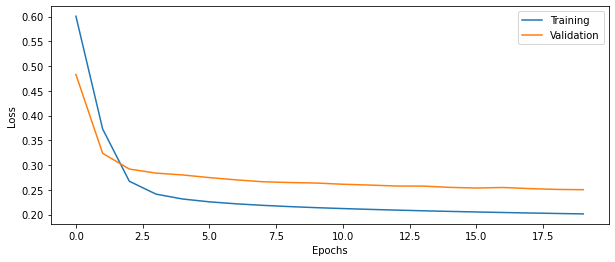

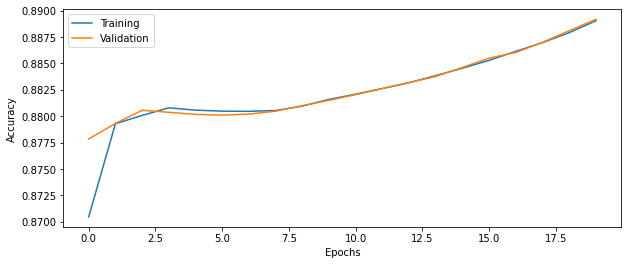

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_642 (Dense)           (None, 50)                3450      
                                                                 
 dense_643 (Dense)           (None, 50)                2550      
                                                                 
 dense_644 (Dense)           (None, 1)                 51        
                                                                 
Total params: 6,051
Trainable params: 6,051
Non-trainable params: 0
_________________________________________________________________


In [232]:
plot_results(history4)

model4.summary()

### 4 layers, 50 nodes, class weights

In [233]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 50
n_layers = 4
input_shape = Xtrain.shape[1]

# Build and train model
model5 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1)

history5 = model5.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 17ms/step - loss: 0.6948 - accuracy: 0.4048 - val_loss: 0.6890 - val_accuracy: 0.8397
Epoch 2/20
69/69 [==============================] - 1s 16ms/step - loss: 0.6936 - accuracy: 0.5123 - val_loss: 0.6933 - val_accuracy: 0.3406
Epoch 3/20
69/69 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5284 - val_loss: 0.6912 - val_accuracy: 0.8535
Epoch 4/20
69/69 [==============================] - 1s 16ms/step - loss: 0.6918 - accuracy: 0.5848 - val_loss: 0.6927 - val_accuracy: 0.8323
Epoch 5/20
69/69 [==============================] - 1s 15ms/step - loss: 0.6907 - accuracy: 0.6676 - val_loss: 0.6907 - val_accuracy: 0.8719
Epoch 6/20
69/69 [==============================] - 1s 16ms/step - loss: 0.6894 - accuracy: 0.7067 - val_loss: 0.6817 - val_accuracy: 0.8483
Epoch 7/20
69/69 [==============================] - 1s 16ms/step - loss: 0.6876 - accuracy: 0.7324 - val_loss: 0.6859 - val_accuracy: 0.8767
Epoch 8/20
69

In [234]:
# Evaluate model on test data
score = model5.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 562us/step - loss: 0.2739 - accuracy: 0.8794
Test loss: 0.2739
Test accuracy: 0.8794


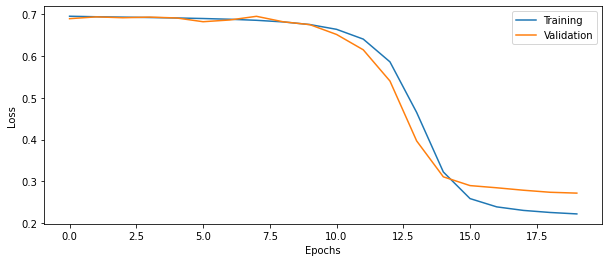

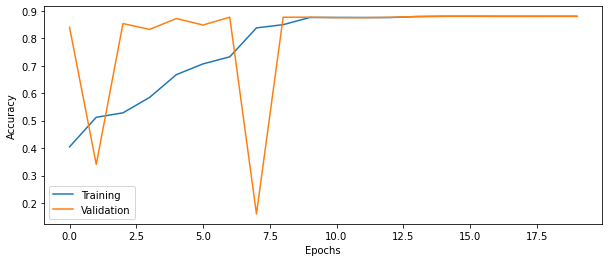

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_645 (Dense)           (None, 50)                3450      
                                                                 
 dense_646 (Dense)           (None, 50)                2550      
                                                                 
 dense_647 (Dense)           (None, 50)                2550      
                                                                 
 dense_648 (Dense)           (None, 50)                2550      
                                                                 
 dense_649 (Dense)           (None, 1)                 51        
                                                                 
Total params: 11,151
Trainable params: 11,151
Non-trainable params: 0
_________________________________________________________________


In [235]:
plot_results(history5)

model5.summary()

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

Answer:

Q14: To normalize outputs of interlayers and re centering to minimize training epochs 

### 2 layers, 20 nodes, class weights, batch normalization

In [236]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model6 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1, use_bn = True)

history6 = model6.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 13ms/step - loss: 0.2843 - accuracy: 0.8711 - val_loss: 0.4036 - val_accuracy: 0.8398
Epoch 2/20
69/69 [==============================] - 1s 11ms/step - loss: 0.2176 - accuracy: 0.8919 - val_loss: 0.3837 - val_accuracy: 0.8398
Epoch 3/20
69/69 [==============================] - 1s 11ms/step - loss: 0.2016 - accuracy: 0.8991 - val_loss: 0.3258 - val_accuracy: 0.8398
Epoch 4/20
69/69 [==============================] - 1s 11ms/step - loss: 0.1939 - accuracy: 0.9017 - val_loss: 0.2452 - val_accuracy: 0.8435
Epoch 5/20
69/69 [==============================] - 1s 11ms/step - loss: 0.1890 - accuracy: 0.9032 - val_loss: 0.1941 - val_accuracy: 0.8893
Epoch 6/20
69/69 [==============================] - 1s 11ms/step - loss: 0.1857 - accuracy: 0.9043 - val_loss: 0.1810 - val_accuracy: 0.9096
Epoch 7/20
69/69 [==============================] - 1s 11ms/step - loss: 0.1829 - accuracy: 0.9059 - val_loss: 0.1898 - val_accuracy: 0.9134
Epoch 8/20
69

In [237]:
# Evaluate model on test data
score = model6.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 557us/step - loss: 0.2180 - accuracy: 0.9129
Test loss: 0.2180
Test accuracy: 0.9129


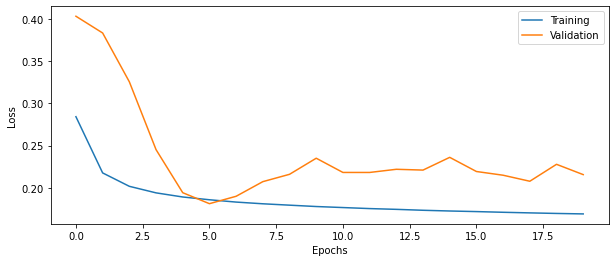

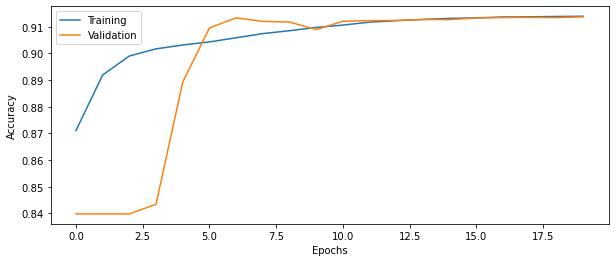

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_650 (Dense)           (None, 20)                1380      
                                                                 
 batch_normalization_421 (Ba  (None, 20)               80        
 tchNormalization)                                               
                                                                 
 dense_651 (Dense)           (None, 20)                420       
                                                                 
 batch_normalization_422 (Ba  (None, 20)               80        
 tchNormalization)                                               
                                                                 
 dense_652 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,981
Trainable params: 1,901
Non-train

In [238]:
plot_results(history6)

model6.summary()

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [239]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model7 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1, use_bn = False, act_fun = 'relu')

history7 = model7.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 6ms/step - loss: 0.3240 - accuracy: 0.8808 - val_loss: 0.2804 - val_accuracy: 0.8846
Epoch 2/20
69/69 [==============================] - 0s 5ms/step - loss: 0.2126 - accuracy: 0.8880 - val_loss: 0.2582 - val_accuracy: 0.8914
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.2002 - accuracy: 0.8946 - val_loss: 0.2456 - val_accuracy: 0.8963
Epoch 4/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1935 - accuracy: 0.8983 - val_loss: 0.2397 - val_accuracy: 0.8993
Epoch 5/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1891 - accuracy: 0.9002 - val_loss: 0.2360 - val_accuracy: 0.9005
Epoch 6/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1857 - accuracy: 0.9010 - val_loss: 0.2306 - val_accuracy: 0.9012
Epoch 7/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1833 - accuracy: 0.9015 - val_loss: 0.2304 - val_accuracy: 0.9016
Epoch 8/20
69/69 [==

In [240]:
# Evaluate model on test data
score = model7.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 519us/step - loss: 0.2177 - accuracy: 0.9100
Test loss: 0.2177
Test accuracy: 0.9100


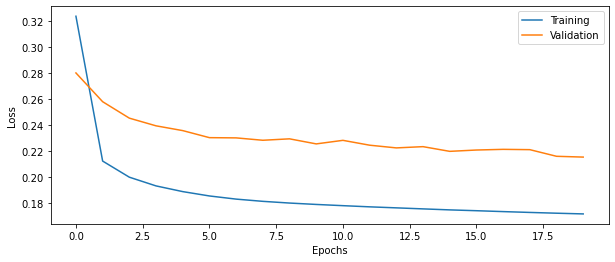

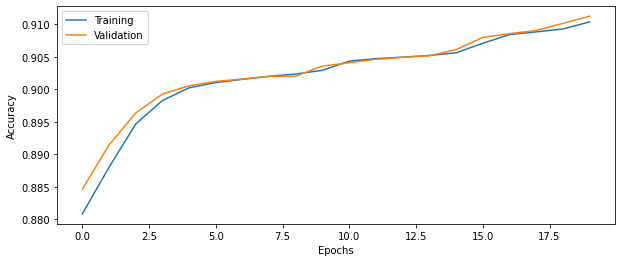

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_653 (Dense)           (None, 20)                1380      
                                                                 
 dense_654 (Dense)           (None, 20)                420       
                                                                 
 dense_655 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [241]:
plot_results(history7)

model7.summary()

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [242]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model8 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1 , use_bn=False, act_fun = 'sigmoid', optimizer = 'Adam')

history8 = model8.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 7ms/step - loss: 0.2534 - accuracy: 0.8576 - val_loss: 0.2643 - val_accuracy: 0.8801
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.1952 - accuracy: 0.8955 - val_loss: 0.2359 - val_accuracy: 0.9047
Epoch 3/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1761 - accuracy: 0.9111 - val_loss: 0.2205 - val_accuracy: 0.9155
Epoch 4/20
69/69 [==============================] - 0s 6ms/step - loss: 0.1695 - accuracy: 0.9158 - val_loss: 0.2124 - val_accuracy: 0.9158
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.1643 - accuracy: 0.9172 - val_loss: 0.2049 - val_accuracy: 0.9172
Epoch 6/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1617 - accuracy: 0.9178 - val_loss: 0.2036 - val_accuracy: 0.9180
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.1606 - accuracy: 0.9179 - val_loss: 0.2161 - val_accuracy: 0.9169
Epoch 8/20
69/69 [==

In [243]:
# Evaluate model on test data
score = model8.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 530us/step - loss: 0.2009 - accuracy: 0.9176
Test loss: 0.2009
Test accuracy: 0.9176


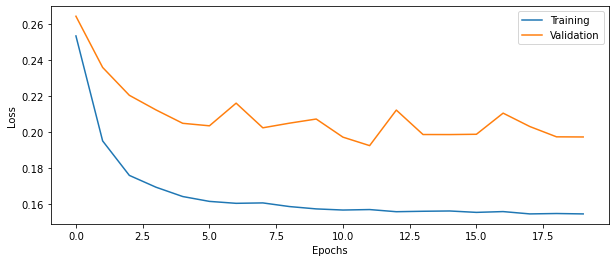

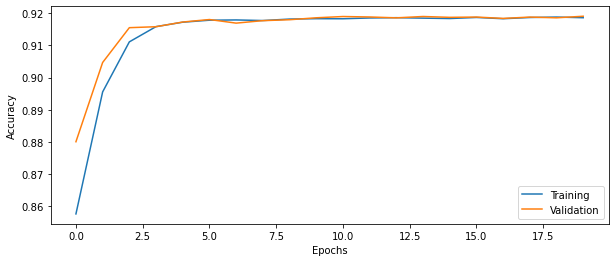

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_656 (Dense)           (None, 20)                1380      
                                                                 
 dense_657 (Dense)           (None, 20)                420       
                                                                 
 dense_658 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [244]:
plot_results(history8)

model8.summary()

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?

Answer:

Q15: The validation accuracy has been pretty much unchanged in this case but the validation loss is much more in line with the training loss by adding dropout.

Q16: The test accuracy has decreased adding the dropout.

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [249]:
# Setup some training parameters
batch_size = 10000
epochs = 20
n_nodes = 20
n_layers = 2
input_shape = Xtrain.shape[1]

# Build and train model
model9 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.1 , use_bn=False, act_fun = 'sigmoid', optimizer = 'sgd', use_dropout = True)

history9 = model9.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6333 - accuracy: 0.6831 - val_loss: 0.5466 - val_accuracy: 0.8783
Epoch 2/20
69/69 [==============================] - 1s 8ms/step - loss: 0.4969 - accuracy: 0.8275 - val_loss: 0.3964 - val_accuracy: 0.8799
Epoch 3/20
69/69 [==============================] - 1s 8ms/step - loss: 0.3747 - accuracy: 0.8669 - val_loss: 0.3233 - val_accuracy: 0.8798
Epoch 4/20
69/69 [==============================] - 1s 8ms/step - loss: 0.3152 - accuracy: 0.8742 - val_loss: 0.3023 - val_accuracy: 0.8798
Epoch 5/20
69/69 [==============================] - 1s 8ms/step - loss: 0.2875 - accuracy: 0.8768 - val_loss: 0.2968 - val_accuracy: 0.8798
Epoch 6/20
69/69 [==============================] - 1s 9ms/step - loss: 0.2753 - accuracy: 0.8776 - val_loss: 0.2937 - val_accuracy: 0.8798
Epoch 7/20
69/69 [==============================] - 1s 8ms/step - loss: 0.2667 - accuracy: 0.8783 - val_loss: 0.2924 - val_accuracy: 0.8798
Epoch 8/20
69/69 [=

In [250]:
# Evaluate model on test data
score = model9.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


2388/2388 [==============================] - 1s 534us/step - loss: 0.2748 - accuracy: 0.8791
Test loss: 0.2748
Test accuracy: 0.8791


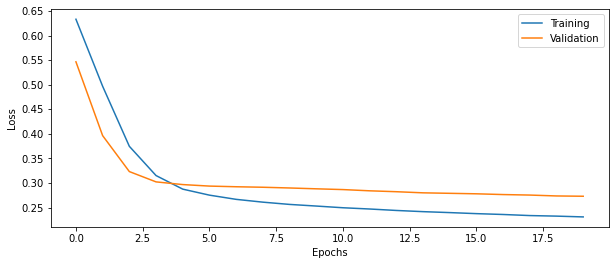

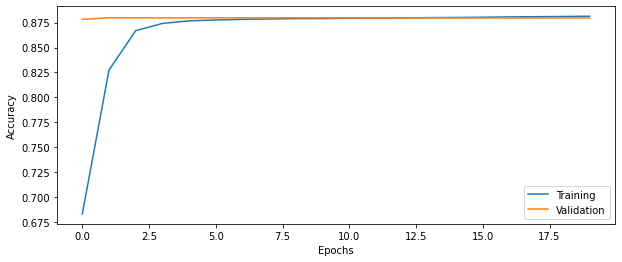

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_669 (Dense)           (None, 20)                1380      
                                                                 
 dropout_395 (Dropout)       (None, 20)                0         
                                                                 
 dense_670 (Dense)           (None, 20)                420       
                                                                 
 dropout_396 (Dropout)       (None, 20)                0         
                                                                 
 dense_671 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [251]:
plot_results(history9)

model9.summary()

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

Answer:

Q17: 
accuracy achieved: 92%, 
with the config: nodes = 100, layers = 6, epochs = 20, batch_size = 1000, Optimizer = adam, activation function = relu, lr = 0.001, use_bn = True, use_dropout = True

In [252]:
# Find your best configuration for the DNN
batch_size = 1000
epochs = 20
n_nodes = 100
n_layers = 6
input_shape = Xtrain.shape[1]

# Build and train model
model10 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.001 , use_bn=True, act_fun = 'relu', optimizer = 'adam', use_dropout = True)

history10 = model10.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
688/688 [==============================] - 15s 20ms/step - loss: 0.2286 - accuracy: 0.8975 - val_loss: 0.2093 - val_accuracy: 0.9136
Epoch 2/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1734 - accuracy: 0.9135 - val_loss: 0.2134 - val_accuracy: 0.9141
Epoch 3/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1678 - accuracy: 0.9145 - val_loss: 0.2030 - val_accuracy: 0.9153
Epoch 4/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1643 - accuracy: 0.9154 - val_loss: 0.2058 - val_accuracy: 0.9146
Epoch 5/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1606 - accuracy: 0.9168 - val_loss: 0.1938 - val_accuracy: 0.9180
Epoch 6/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1589 - accuracy: 0.9176 - val_loss: 0.1938 - val_accuracy: 0.9191
Epoch 7/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1576 - accuracy: 0.9174 - val_loss: 0.1890 - val_accuracy:

2388/2388 [==============================] - 2s 793us/step - loss: 0.1860 - accuracy: 0.9192
Test loss: 0.1860
Test accuracy: 0.9192
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_672 (Dense)           (None, 100)               6900      
                                                                 
 batch_normalization_429 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_397 (Dropout)       (None, 100)               0         
                                                                 
 dense_673 (Dense)           (None, 100)               10100     
                                                                 
 batch_normalization_430 (Ba  (None, 100)              400       
 tchNormalization)                                  

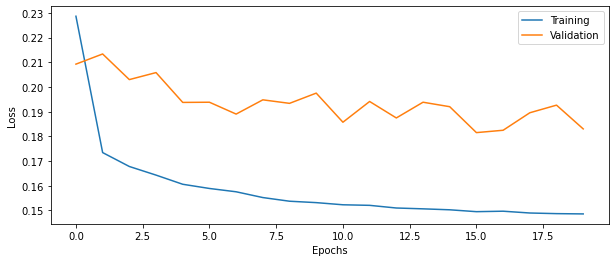

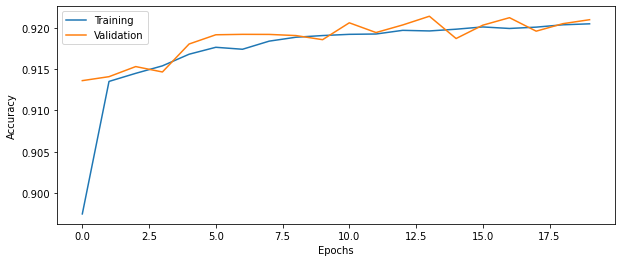

In [253]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest,Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])


model10.summary()
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

Answer:

Q18: 
Mean:0.9181716650724411 so 91.8%
Standard deviation: 0.00011050742497226597 so around 0.01%


In [254]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [255]:
# Find your best configuration for the DNN
batch_size = 1000
epochs = 20
n_nodes = 100
n_layers = 6
input_shape = Xtrain.shape[1]

# Build and train model
model11 = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.001 , use_bn=True, act_fun = 'relu', optimizer = 'adam', use_custom_dropout = True)

history11 = model11.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xval,Yval), epochs = epochs, class_weight=class_weights ) 

Epoch 1/20
688/688 [==============================] - 14s 19ms/step - loss: 0.2237 - accuracy: 0.9014 - val_loss: 0.2343 - val_accuracy: 0.9112
Epoch 2/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1744 - accuracy: 0.9134 - val_loss: 0.2276 - val_accuracy: 0.9134
Epoch 3/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1675 - accuracy: 0.9151 - val_loss: 0.2156 - val_accuracy: 0.9145
Epoch 4/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1630 - accuracy: 0.9166 - val_loss: 0.2160 - val_accuracy: 0.9161
Epoch 5/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1603 - accuracy: 0.9174 - val_loss: 0.1995 - val_accuracy: 0.9171
Epoch 6/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1585 - accuracy: 0.9178 - val_loss: 0.2074 - val_accuracy: 0.9186
Epoch 7/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1567 - accuracy: 0.9184 - val_loss: 0.1966 - val_accuracy:

2388/2388 [==============================] - 3s 1ms/step - loss: 0.1950 - accuracy: 0.9180
Test accuracy: 0.9180
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_679 (Dense)           (None, 100)               6900      
                                                                 
 batch_normalization_435 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 my_dropout_39 (myDropout)   (None, 100)               0         
                                                                 
 dense_680 (Dense)           (None, 100)               10100     
                                                                 
 batch_normalization_436 (Ba  (None, 100)              400       
 tchNormalization)                                               
      

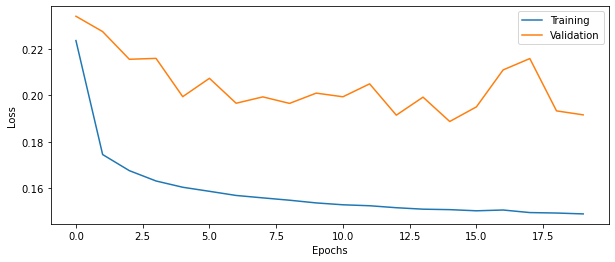

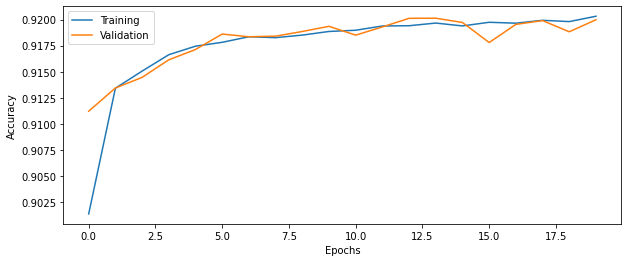

In [256]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest,Ytest)
                       
print('Test accuracy: %.4f' % score[1])

model11.summary()

plot_results(history11)

In [257]:
# Run the testing 100 times, and save the accuracies in an array
times = 100
acca = np.zeros(times)
for i in range(times):
    score = model11.evaluate(Xtest,Ytest)
    acca[i] = score[1]
    
    
# Calculate and print mean and std of accuracies

mean_100 = np.mean(acca)
std_100 = np.std(acca)
print(mean_100)
print(std_100)

2388/2388 [==============================] - 3s 1ms/step - loss: 0.1955 - accuracy: 0.9180
0.9181716650724411
0.00011050742497226597


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

Answer:

Q19: 
mean: 0.9200653036435446
std:  0.0009349460863567071

Q20: Especially in DNN with large data sets, CV would be overfitting to just a part of the whole big dataset since the big data set will be more sensitive to overfitting. Dropout is desirable to minimize this overfitting. CV also takes longer time to train.

In [258]:
from sklearn.model_selection import StratifiedKFold
batch_size = 1000
epochs = 20
n_nodes = 100
n_layers = 6
input_shape = Xtrain.shape[1]
acca = np.zeros(10)


# Define 10-fold cross validation
fold = StratifiedKFold(10)
# Loop over cross validation folds
i = 0
for train_index, test_index in fold.split(X, Y):

    Xtrain, Ytrain, Xtest, Ytest = X[train_index], Y[train_index], X[test_index], Y[test_index]
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight("balanced", np.unique(Ytrain), Ytrain)
    class_weights = {j: class_weights[j] for j in [0,1]} 
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    modelcv = build_DNN(input_shape,n_layers,n_nodes,learning_rate=0.001 , use_bn=True, act_fun = 'relu', optimizer = 'adam', use_custom_dropout = True)
    
    # Fit the model with training set and class weights for this fold
    historycv = modelcv.fit(x=Xtrain, y=Ytrain , batch_size=batch_size , validation_data = (Xtest,Ytest), epochs = epochs, class_weight=class_weights ) 
    
    # Evaluate the model using the test set for this fold
    score = modelcv.evaluate(Xtest,Ytest)
    
    # Save the test accuracy in an array
    acca[i] = score[1]
    
    i=i+1

# Calculate and print mean and std of accuracies
print(np.mean(acca))
print(np.std(acca))



C:\Users\dinud\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/20
688/688 [==============================] - 15s 20ms/step - loss: 0.2268 - accuracy: 0.8998 - val_loss: 0.2239 - val_accuracy: 0.9118
Epoch 2/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1744 - accuracy: 0.9131 - val_loss: 0.2169 - val_accuracy: 0.9131
Epoch 3/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1687 - accuracy: 0.9144 - val_loss: 0.2053 - val_accuracy: 0.9134
Epoch 4/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1657 - accuracy: 0.9150 - val_loss: 0.2114 - val_accuracy: 0.9139
Epoch 5/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1632 - accuracy: 0.9158 - val_loss: 0.2100 - val_accuracy: 0.9157
Epoch 6/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1612 - accuracy: 0.9167 - val_loss: 0.2081 - val_accuracy: 0.9152
Epoch 7/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1586 - accuracy: 0.9179 - val_loss: 0.2008 - val_accuracy:

Epoch 11/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1540 - accuracy: 0.9186 - val_loss: 0.1905 - val_accuracy: 0.9196
Epoch 12/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1532 - accuracy: 0.9191 - val_loss: 0.1903 - val_accuracy: 0.9203
Epoch 13/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1522 - accuracy: 0.9192 - val_loss: 0.1907 - val_accuracy: 0.9198
Epoch 14/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1516 - accuracy: 0.9192 - val_loss: 0.1910 - val_accuracy: 0.9201
Epoch 15/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1514 - accuracy: 0.9190 - val_loss: 0.2210 - val_accuracy: 0.9200
Epoch 16/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1509 - accuracy: 0.9194 - val_loss: 0.2015 - val_accuracy: 0.9200
Epoch 17/20
688/688 [==============================] - 13s 19ms/step - loss: 0.1507 - accuracy: 0.9194 - val_loss: 0.1893 - val_ac

Epoch 6/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1581 - accuracy: 0.9178 - val_loss: 0.2058 - val_accuracy: 0.9170
Epoch 7/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1574 - accuracy: 0.9180 - val_loss: 0.1961 - val_accuracy: 0.9181
Epoch 8/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1555 - accuracy: 0.9185 - val_loss: 0.1915 - val_accuracy: 0.9179
Epoch 9/20
688/688 [==============================] - 14s 21ms/step - loss: 0.1546 - accuracy: 0.9184 - val_loss: 0.2054 - val_accuracy: 0.9188
Epoch 10/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1537 - accuracy: 0.9187 - val_loss: 0.1886 - val_accuracy: 0.9190
Epoch 11/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1524 - accuracy: 0.9191 - val_loss: 0.1908 - val_accuracy: 0.9192
Epoch 12/20
688/688 [==============================] - 14s 20ms/step - loss: 0.1521 - accuracy: 0.9191 - val_loss: 0.1956 - val_accura

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN in order to use it for regression instead?

Answer:

Q21: We should not use any activation function in the ouput so that the activation will be linear.

## Report

Send in this jupyter notebook, with answers to all questions.